# Deep Learning
## Formative assessment
### Week 5: Convolutional neural networks

#### Instructions

In this notebook, you will write code to compute saliency maps for a pre-trained CNN model.

Some code cells are provided you in the notebook. You should avoid editing provided code, and make sure to execute the cells in order to avoid unexpected errors. Some cells begin with the line: 

`#### GRADED CELL ####`

These cells require you to write your own code to complete them.

#### Let's get started!

We'll start by running some imports, and loading the dataset. 

In [2]:
#### PACKAGE IMPORTS ####

# Run this cell first to import all required packages. Do not make any imports elsewhere in the notebook

import tensorflow as tf
import numpy as np
import os
import json
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from pathlib import Path

# If you would like to make further imports from Tensorflow, add them here


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))




Num GPUs Available:  1


<img src="figures/imagenet.jpeg" title="ImageNet" style="width: 650px;"/>  
  
#### The ImageNet dataset

In the first part of this assignment, you will use a subset of the [ImageNet dataset](http://www.image-net.org). This is a large-scale image classification dataset, that is organised according to the [WordNet](https://wordnet.princeton.edu) hierarchy. It contains over 20,000 categories, with hundreds of images per category. See [here](http://image-net.org/about-stats) for summary statistics of the ImageNet dataset. 

* Deng, J., Dong, W., Socher, R., Li, L.-J., Li, K. & Fei-Fei, L. (2009), "ImageNet: A Large-Scale Hierarchical Image Database", _IEEE Computer Vision and Pattern Recognition (CVPR)_.
* Deng, J., Li, K., Do, M., Su, H., Fei-Fei, L. (2009), "Construction and Analysis of a Large Scale Image Ontology", in _Vision Sciences Society (VSS)_.
* Russakovsky, O., Deng, J., Su, H., Krause, J., Satheesh, S., Ma, S., Huang, Z., Karpathy, A., Khosla, A., Bernstein, M., Berg, A. C., & Fei-Fei, L. (2015), "ImageNet Large Scale Visual Recognition Challenge", *International Journal of Computer Vision (IJCV)*, **115** (3), 211-252.

Your goal is to use a convolutional neural network pre-trained on the ImageNet dataset, to compute saliency maps that analyse the sensitivity of network predictions to pixels in the input.

#### Saliency maps

Saliency maps are an important general concept in computer vision that refer to a group of techniques for highlighting specific features in an image (such as the pixels) that are the most conspicous (or salient) in relation to some property of the image (typically summarised as a scalar value). For example, consider how colour images can be converted to black-and-white to analyse colour intensity, or how night vision can be used to detect light sources.

In the context of deep learning models, saliency maps have been used as a means to make network predictions more interpretable. They can be used to analyse the sensitivity of network predictions to pixels in the input. In other words, they highlight which pixels affect the network prediction the most - the underlying assumption being that such pixels will most likely correspond to the object being classified.

#### Load the pre-trained CNN model

For this part of the assignment, we will use a VGG16 convolutional neural network (CNN) that has been pre-trained on the ImageNet dataset. The VGG network is an important CNN architecture that was developed by the [Visual Geometry Group](https://www.robots.ox.ac.uk/~vgg/) at the University of Oxford. 

* Simonyan, K. & Zisserman, A. (2015), "Very Deep Convolutional Networks for Large-Scale Image Recognition", *International Conference on Learning Representations (ICLR)*, San Diego, CA, USA, May 7-9, 2015.

This model is available to download directly from `tf.keras.applications`. You should now complete the following function to download this model. 

* The function should instantiate the VGG16 model from `tf.keras.applications` (see the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16))
* The model should use weights learned from pre-training on ImageNet
* It should include the final `Dense` layers of the architecture
* It should return the logits in the final layer (i.e. the softmax activation should be removed)
* Your function should then return the model

In [3]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_vgg16():
    """
    This function should download the VGG16 model as specified above.
    The function should then return the model instance.
    """
    vgg16 = tf.keras.applications.VGG16(include_top=True, weights='imagenet', classifier_activation=None) 
    return vgg16

In [4]:
# Run your function to instantiate the VGG16 model

vgg16 = get_vgg16()

553467096/553467096 [==============================] - 56s 0us/step


In [5]:
# Print the model summary

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### Load and preprocess images and labels

For this assignment, you will use a random sample of 1% of the images from the validation set of the ImageNet dataset. Note that the full dataset can be downloaded from [here](http://www.image-net.org/challenges/LSVRC/2012/downloads), but it is not necessary to download it for this assignment. 

In addition, the ground truth labels are already available in the json files `labels.json`, `synset.json` and `synset_words.json`.

* The `labels.json` file is a dictionary mapping each filename in the (full) validation set to a label index. This index matches with the index of the network output
* Labels in ImageNet are organised in 'synsets' (synonym sets), consisting of multiple words or phrases
* The `synsets.json` file contains the codes for each of the 1000 synsets predicted by VGG16, organised in the same order as the network output indices
* Finally, `synset_words.json` maps synset codes to human-readable text descriptions

The following cell loads each of these json files.

In [6]:
# Load the label data

def load_json(path):
    with open(path, 'r') as json_file:
        j = json.load(json_file)
    return j

labels = load_json(Path('./data/labels.json'))
synsets = load_json(Path('./data/synsets.json'))
synset_words = load_json(Path('./data/synset_words.json'))

In [7]:
# Get a list of image file paths

img_filepaths = list(Path('./data/images').glob("*"))

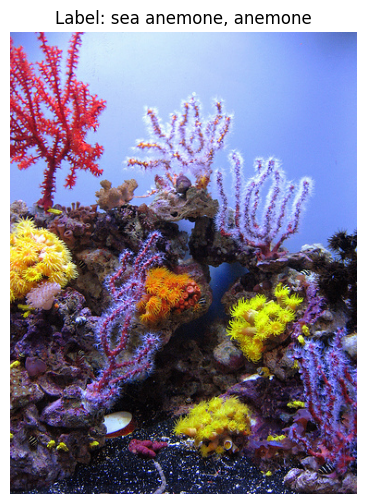

In [21]:
# View a sample image and label

def sample_random_image_and_label():
    i = np.random.choice(len(img_filepaths))
    img_filepath = img_filepaths[i]
    filename = img_filepath.name
    label_inx = labels[filename]
    synset = synsets[label_inx]
    words_label = synset_words[synset]
    return str(img_filepath), words_label

img_file, label = sample_random_image_and_label()
raw_img = tf.io.read_file(img_file)
img_tensor = tf.io.decode_jpeg(raw_img, channels=3)

plt.figure(figsize=(8, 6))
plt.imshow(img_tensor.numpy())
plt.axis('off')
plt.title("Label: {}".format(label))
plt.show()

As can be seen from the model summary, the VGG16 model expects an input image with shape `(224, 224, 3)`. However, the images in the dataset come in varying sizes, as can be seen from the sample above. 

You should now complete the following function, that will load and preprocess an image from file.

* The function takes a `filepath` and `shape` as arguments
* It should load the image from file into a Tensor (see the example code above)
* It should then resize the image according to the `shape` argument (*hint: see the* `tf.image.resize` *function*)
* The function should then return the resized image Tensor

In [22]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def load_and_resize_image(filepath, shape):
    """
    This function should load an image from file, and resize it according to the
    instructions above.
    It should then return the resized image Tensor.
    """
    raw_img = tf.io.read_file(filepath)
    img_tensor = tf.io.decode_jpeg(raw_img, channels=3)
    img_tensor = tf.image.resize(img_tensor, tf.constant(shape[:2]))
    return img_tensor
    

In [23]:
# Test your function on a random image

img_file, _ = sample_random_image_and_label()
resized_img = load_and_resize_image(img_file, (224, 224, 3))
resized_img.shape

TensorShape([224, 224, 3])

#### Get model predictions
The VGG16 model requires images to be preprocessed before being passed through the model (see the [docs](https://www.tensorflow.org/api_docs/python/tf/keras/applications/VGG16)). The `tf.keras.applications.vgg16` module provides a convenient function `preprocess_input` for this, as well as a `decode_predictions` function to help with interpreting model predictions.

You should now complete the following function to get the model predictions from a resized image Tensor.

* The function takes the `vgg16` model, `resized_img` as an argument, as output from the `load_and_resize_image` function
* It should process the image Tensor using the `preprocess_input` function
* The function should then compute the `vgg16` model predictions on the image Tensor, using a batch size of one
* It should then collect the top 3 predictions using the `decode_predictions` function
  * This will be returned as a list containing a list of 3-tuples `(synset_code, word_label, logit)` for each of the top 3 predictions
* The function should then return the model's logit predictions, and the top 3 `decode_predictions` output as a tuple `(preds, decoded_preds)`

In [31]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def get_model_predictions(vgg16, resized_img):
    """
    This function should process a resized image and compute model predictions
    as described above.
    It should return a tuple of 2 elements (preds, decoded_predictions), where preds
    is the model logit predictions, and decoded_predictions are the decoded top 3 predictions.
    """
    resized_img = tf.keras.applications.vgg16.preprocess_input(resized_img)
    #need first dimension to be batch
    preds = vgg16(resized_img[None,:])
    decoded = tf.keras.applications.vgg16.decode_predictions(preds.numpy(), top=3)
    return preds, decoded
    

In [45]:
# Test your function on a randomly selected image

img_file, label = sample_random_image_and_label()
resized_img = load_and_resize_image(img_file, (224, 224, 3))
preds, decoded_preds = get_model_predictions(vgg16, resized_img)

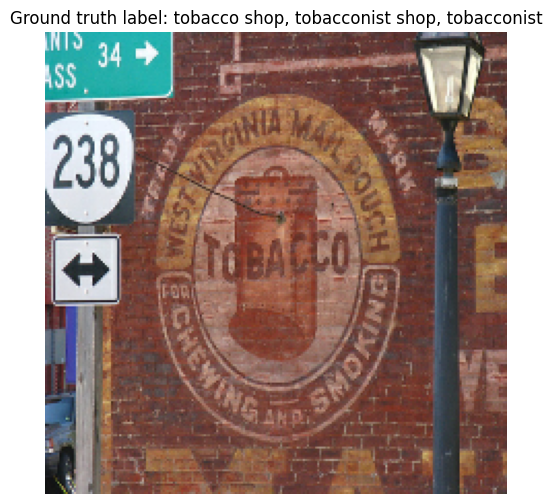

Model predictions:
[[('n03891332', 'parking_meter', 7.1714315), ('n04141975', 'scale', 7.0896254), ('n06794110', 'street_sign', 6.6219287)]]


In [46]:
# View the image, ground truth label and model predictions

plt.figure(figsize=(8, 6))
plt.imshow(resized_img.numpy() / 255.)
plt.axis('off')
plt.title("Ground truth label: {}".format(label))
plt.show()

print("Model predictions:\n{}".format(decoded_preds))

You are now ready to compute the saliency map of the model on a randomly selected image. The saliency map should be computed by calculating the gradient of the model's top-scoring logit prediction with respect to the input image.

You should now complete the following function to compute the saliency map.

* The function takes the `vgg16` model and `resized_img` as input arguments, as well as the `get_model_predictions` function
* It should compute the model predictions using `get_model_predictions`
* The function should calculate which logit has the maximum score out of the model predictions
* Using automatic differentiation, it should then compute the gradient of this logit with respect to the input image Tensor
* This will give gradients of shape `(224, 224, 3)`. To display the saliency map, the function should take the maximum absolute value of the gradient over the channel dimensions at each spatial location
  * This will result in a Tensor of shape `(224, 224)`
* The function should then return the resulting saliency map Tensor and the decoded predictions in a tuple `(sm, decoded_preds)`

In [47]:
#### GRADED CELL ####

# Complete the following function.
# Make sure not to change the function name or arguments.

def saliency_map(vgg16, resized_img, get_model_predictions=get_model_predictions):
    """
    This function should compute the saliency map as described above.
    It should return the tuple (saliency_map, decoded_predictions).
    """
    with tf.GradientTape() as tape:
        tape.watch(resized_img)
        preds, decoded = get_model_predictions(vgg16, resized_img)
        preds = tf.squeeze(preds)
        argmax = tf.math.argmax(preds)
        max_logit = preds[argmax]
    #gradient of max logit wrt resized image
    grads = tape.gradient(max_logit, resized_img)
    return tf.reduce_max(tf.math.abs(grads), axis=-1), decoded
    

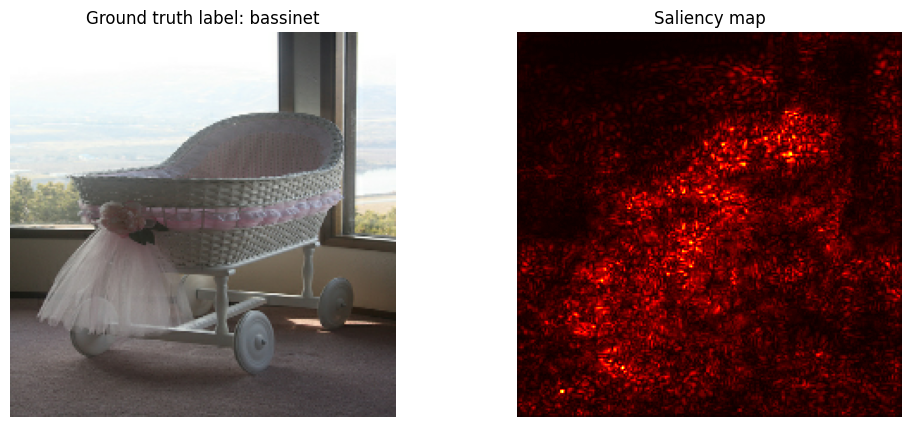

Model predictions:
[[('n02804414', 'bassinet', 7.291529), ('n03777568', 'Model_T', 6.2561803), ('n04204347', 'shopping_cart', 6.0864506)]]


In [56]:
# Compute the saliency map for a randomly selected image

img_file, label = sample_random_image_and_label()
resized_img = load_and_resize_image(img_file, (224, 224, 3))
sm, decoded_preds = saliency_map(vgg16, resized_img)

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.imshow(resized_img.numpy() / 255.)
plt.axis('off')
plt.title("Ground truth label: {}".format(label))

plt.subplot(122)
plt.imshow(sm.numpy(), cmap='hot')
plt.axis('off')
plt.title("Saliency map")
plt.show()

print("Model predictions:\n{}".format(decoded_preds))

Note how the saliency maps highlight the regions of the image that give rise to the model's top prediction. Usually this is centred on the object location (particularly when the model prediction is correct), but can also sometimes show other features of the image that help the model to make its prediction.

Congratulations on completing this week's assignment! You have now seen how to compute saliency maps for a pre-trained CNN model.